In [1]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA 

In [2]:
#only if GPU is available
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Utils functions for Word Embeddings

In [3]:
def load_embeddings(file_path) :
    '''
    parameters : file_path - path of file where embeddings are stored (eg: '<path>/glove.6B/glove.6B.100d.txt')
    load the words and their respective embeddings from the GloVe file and set up a dictionary mapping 
    of words and their corresponding embeddings (embeddings will be stored in a numpy array of shape (d, ))
    returns : embedding_dict - dictionary mapping of {word:embedding}
    ''' 
    
    embedding_dict = {}
    file = open(file_path)
    for line in file :
        data = line.split(" ")
        word = data[0]
        embedding = np.asarray(data[1:], dtype='float32')
        embedding_dict[word] = embedding
    file.close()
    return embedding_dict

In [4]:
def set_embedding_matrix(embedding_dict, vocabulary, embedding_dimension) :
    '''
    parameters : embedding dict - dictionary mapping of {word:embedding} 
                 vocabulary - numpy array words in the training dataset of shape (n,)
                 embedding_dimension - dimension of word embeddings used in the model
    initialises the embedding matrix with the ith row corresponding to the embedding of the ith word in the vocabulary
    dimension of the embedding depends on the 
    returns : embedding_matrix of shape (n, d) where n is the number of words in the vocabulary and d is the 
              dimension of the embeddings
    '''
    
    embedding_matrix = np.random.normal(0, 0.1, (len(vocabulary) + 1, embedding_dimension))
    for i, word in enumerate(vocabulary) :
        if word in embedding_dict.keys() :
            word_embedding = embedding_dict[word]
            embedding_matrix[i] = word_embedding
    return embedding_matrix

    

In [5]:
def get_rand_embedding_layer(vocabulary_size, embedding_dimension, max_length) :
    '''
    parameters : vocabulary - dictionary with a mapping of {word : integer}
                 embedding_dimension - integer which indicated the dimension of the word embeddings
                 max_length - maximum length of the input to the model(eg : maximum length of an input sentence)
    creates the embedding layer with trainable set to true so that weights cannot be changed during training.
    Weights of the embedding layer follow normal distribution with mean=0, stddev=0.1
    returns : embedding_layer 
    '''
    
    embedding_matrix = np.random.normal(0, 0.1, (vocabulary_size, embedding_dimension))
    embedding_layer = layers.Embedding(input_dim=vocabulary_size,
                                      output_dim=embedding_dimension,
                                      input_length=max_length,
                                      weights=[embedding_matrix],
                                      trainable=True,
                                      name='embedding_rand')
    return embedding_layer


def get_static_embedding_layer(embedding_matrix, max_length) :
    '''
    parameters : embedding_matrix - numpy array of shape (n, d) used to set the weights of the embedding layer
                 max_length - maximum length of the input to the model(eg : maximum length of an input sentence)
    creates the embedding layer and sets its weights with trainable set to false 
    so that weights cannot be changed during training
    returns : embedding_layer 
    '''
    
    embedding_layer = layers.Embedding(input_dim=embedding_matrix.shape[0],
                                      output_dim=embedding_matrix.shape[1],
                                      input_length=max_length,
                                      weights=[embedding_matrix],
                                      trainable=False,
                                      name='embedding_static')
    return embedding_layer


def get_dynamic_embedding_layer(embedding_matrix, max_length) :
    '''
    parameters : embedding_matrix - numpy array of shape (n, d) used to set the weights of the embedding layer
                 max_length - maximum length of the input to the model(eg : maximum length of an input sentence)
    creates the embedding layer and sets its weights with trainable set to true 
    so that weights can be changed or fine-tuned during training
    returns : embedding_layer 
    '''
    
    embedding_layer = layers.Embedding(input_dim=embedding_matrix.shape[0],
                                      output_dim=embedding_matrix.shape[1],
                                      input_length=max_length,
                                      weights=[embedding_matrix],
                                      trainable=True,
                                      name='embedding_dynamic')
    return embedding_layer

# Classes for groups of layers 

In [6]:
class CNNBlock(layers.Layer) :
    '''
    Creates a block of 2 layers - 1D Convolutional layer with activation ReLU
                                  Global Max Pooling layer
    '''
    
    def __init__(self, kernel_size, filters=100) :
        '''
        parameters : kernel size - size of the window used in the Conv1D layer. Represents the number of words
                                   considered by each window.
                     filters - (default=100) indicates the number of feature maps produced by the Conv1D layer
        Initialises the 2 layers with the given parameters.
        '''
        
        super(CNNBlock, self).__init__()
        self.conv1d = layers.Conv1D(filters=filters,
                                   kernel_size=kernel_size,
                                   activation='relu',
                                   name=f'conv_1d_{kernel_size}')
        self.pool = layers.GlobalMaxPooling1D()
    def call(self, input_tensor) :
        '''
        parameters : input tensor - input to the Conv1D layer. 
                                    Numpy array of shape (batch_size, num_words, embedding_dimension)
        Overrides the call method in the Layer class. Sets forward pass through the layers.
        returns : output of the last layer(GlobalMaxPooling1D), numpy array of shape (batch_size, filters)       
        '''
        
        x = self.conv1d(input_tensor)
        x = self.pool(x)
        return x

In [7]:
class CNNPool(layers.Layer) :
    '''
    Creates a pool of CNNBlocks - consists of 3 CNNBlocks, each with a different kernel size. Output from each is
    concatenated and returned
    '''
    
    def __init__(self, filters=100) :
        '''
        parameters : filters - (default=100) indicates the number of feature maps produced by the CNNBlock
        Initialises the CNNBlocks with the given parameters 
        '''
        
        super(CNNPool, self).__init__()
        self.block_1 = CNNBlock(3, filters)
        self.block_2 = CNNBlock(4, filters)
        self.block_3 = CNNBlock(5, filters)
        
    def call(self, input_tensor) :
        '''
        parameters : input tensor - input to the CNNBlock. 
                                    Numpy array of shape (batch_size, num_words, embedding_dimension)
        Overrides the call method in the Layer class. Sets forward pass through the layers.
        returns : concatenated output of all the blocks, numpy array of shape (batch_size, filters * num_blocks)
        '''
        
        x1 = self.block_1(input_tensor)
        x2 = self.block_2(input_tensor)
        x3 = self.block_3(input_tensor)
        x = layers.concatenate([x1, x2, x3])
        return x

# ShallowNet model with only static word embeddings

In [38]:
class ShallowNet(keras.Model) :
    '''
    Creates a model for text classification. Consists of
    - embedding layer
    - CNNPool
        - CNNBlocks with kernel sizes {3, 4, 5}
            - Conv1D layer
            - GlobalMaxPooling1D layer
    -fully connected network
        - Dense layer with 64 nodes and ReLU activation
        - Dense layer with num_classes node and sigmoid/softmax activation
    '''
    
    def __init__(self, embedding_matrix, vocabulary_size, max_length, embedding_dimension, num_classes, mode='static') :
        '''
        parameters : embedding_matrix - numpy array of shape (vocabulary_size, embedding_dimension)
                     vocabulary_size - Number of words in the vocabulary
                     max_length - Maximum length of a sentence or input to the model
                     embedding_dimension - size of word embeddings
                     num_classes - number of classes to predict from in the output.
                     mode - {'static', 'dynamic', 'rand'}
                             static initialises the weights with GloVe embeddings and
                                 fixes weights of the embedding layer so there is no change during training
                             dynamic initialises the weights with GloVe embeddings and 
                                 allows the weights of the embedding layer to be changed or fine-tuned during training
                             rand sets the weights randomly and 
                                 allows the weights of the embedding layer to be changed or fine-tuned during train
        Initialises the layers of the model with the given parameters 
        '''
            
        super(ShallowNet, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.vocabulary_size = vocabulary_size
        self.max_length = max_length
        self.embedding_dimension = embedding_dimension
        
        self.embedding_layer = None
        if mode == 'static' :
            self.embedding_layer = get_static_embedding_layer(self.embedding_matrix, self.max_length)
        elif mode == 'dynamic' :
            self.embedding_layer = get_dynamic_embedding_layer(self.embedding_matrix, self.max_length)
        elif mode == 'rand' :
            self.embedding_layer = get_rand_embedding_layer(self.vocabulary_size, self.embedding_dimension, 
                                                            self.max_length)

        self.conv_pool = CNNPool()
        
        self.connected_layer_1 = layers.Dense(64, activation='relu')
        self.connected_layer_2 = None
        if num_classes == 1 :
            self.connected_layer_2 = layers.Dense(num_classes, activation='sigmoid')
        else :
            self.connected_layer_2 = layers.Dense(num_classes, activation='softmax')
        
        
    def call(self, input_tensor) :
        '''
        parameters : input tensor - input to the model. 
                                    Numpy array of shape (batch_size, max_length)
        Sets forward pass through the layers.
        returns : Final output, numpy array of shape (batch_size, num_classes)
        '''
            
        embedding_input = self.embedding_layer(input_tensor)
        x = self.conv_pool(embedding_input)
        x = layers.Dropout(0.5)(x)
        x = layers.Flatten()(x)
        x = self.connected_layer_1(x)
        x = self.connected_layer_2(x)
        return x
    
    def model(self) :
        '''
        returns : ShallowNet model described above
        '''
        x = keras.Input(shape=(self.max_length))
        return keras.Model(inputs=[x], outputs=self.call(x))

# KimNet model with static and dynamic word embeddings

In [39]:
class KimNet(keras.Model) :
    '''
    Creates a model for text classification. Consists of
    - embedding layer {static and dynamic}
    for each embedding layer
        - CNNPool
            - CNNBlocks with kernel sizes {3, 4, 5}
                - Conv1D layer
                - GlobalMaxPooling1D layer
    -fully connected network
        - Dense layer with 64 nodes and ReLU activation
        - Dense layer with num_classes node and sigmoid/softmax activation
    '''
    
    def __init__(self, embedding_matrix, vocabulary_size, max_length, embedding_dimension, num_classes) :
        '''
        parameters : embedding_matrix - numpy array of shape (vocabulary_size, embedding_dimension)
                     vocabulary_size - Number of words in the vocabulary
                     max_length - Maximum length of a sentence or input to the model
                     embedding_dimension - size of word embeddings
                     num_classes - number of classes to predict from in the output.
        Initialises the layers of the model with the given parameters. Initialises 2 embedding layers with GloVe,
        one with fixed weights and the other with dynamic weights.
        '''
            
        super(KimNet, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.vocabulary_size = vocabulary_size
        self.max_length = max_length
        self.embedding_dimension = embedding_dimension

        self.embedding_layer_static = get_static_embedding_layer(self.embedding_matrix, self.max_length)
        self.conv_pool_static = CNNPool()
        
        self.embedding_layer_dynamic = get_dynamic_embedding_layer(self.embedding_matrix, self.max_length)
        self.conv_pool_dynamic = CNNPool()
        
        self.connected_layer_1 = layers.Dense(64, activation='relu')
        self.connected_layer_2 = None
        if num_classes == 1 :
            self.connected_layer_2 = layers.Dense(num_classes, activation='sigmoid')
        else :
            self.connected_layer_2 = layers.Dense(num_classes, activation='softmax')
        
    def call(self, input_tensor) :
        '''
        parameters : input tensor - input to the model. 
                                    Numpy array of shape (batch_size, max_length)
        Sets forward pass through the layers.
        returns : Final output, numpy array of shape (batch_size, num_classes)
        '''
        
        embedding_input_static = self.embedding_layer_static(input_tensor)
        x_static = self.conv_pool_static(embedding_input_static)
        
        embedding_input_dynamic = self.embedding_layer_dynamic(input_tensor)
        x_dynamic = self.conv_pool_dynamic(embedding_input_dynamic)
        
        x = layers.concatenate([x_static, x_dynamic])
        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x)
        x = self.connected_layer_1(x)
        x = self.connected_layer_2(x)
        return x
    
    def model(self) :
        '''
        returns : KimNet model described above
        '''
        x = keras.Input(shape=(self.max_length))
        return keras.Model(inputs=[x], outputs=self.call(x))

In [25]:
# load Glove embeddings(100 dimensional) and convert it into a dictionary with mapping {word:embedding}

file_path = '../GloVe/glove.6B/glove.6B.100d.txt'
embedding_dict = load_embeddings(file_path)

In [45]:
# load vocabulary from a pickle file and set the embedding matrix

vocab_file = open("./data/vocab_imdb.pkl", "rb")
vocabulary = pickle.load(vocab_file)
embedding_matrix = set_embedding_matrix(embedding_dict, vocabulary, 100)

In [72]:
# load training and testing data from an npz file and set max_length of input 
# set vocabulary size to accomodate unknown words
# set number of output classes

data = np.load('./data/encoded_dataset_imdb.npz')
x_train = data['name1']
y_train = data['name2']
x_test = data['name3']
y_test = data['name4']
max_length = x_train.shape[1]
vocabulary_size = len(vocabulary) + 1
num_classes = 1

In [51]:
shallow_model = ShallowNet(embedding_matrix, vocabulary_size, max_length, 100, num_classes, mode='rand')
shallow_model = shallow_model.model()

# ShallowNet

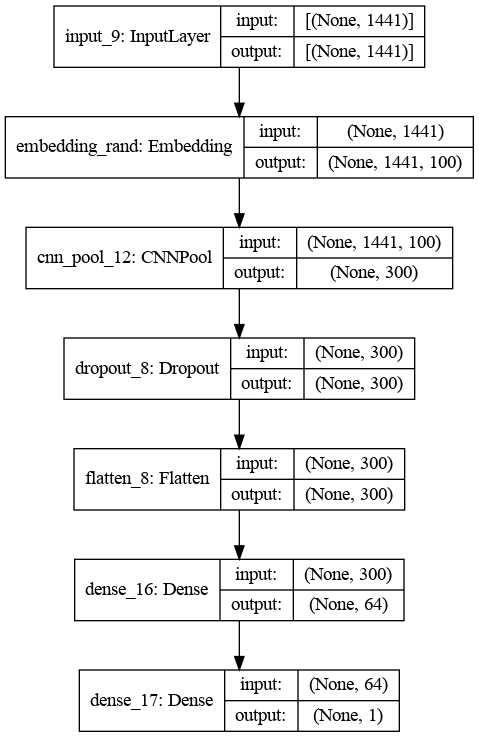

In [52]:
# print(shallow_model.summary())
plot_model(shallow_model, to_file='./assets/shallow_model_plot.png', show_shapes=True, show_layer_names=True)

In [53]:
kim_model = KimNet(embedding_matrix, vocabulary_size, max_length, 100, num_classes)
kim_model = kim_model.model()

# KimNet

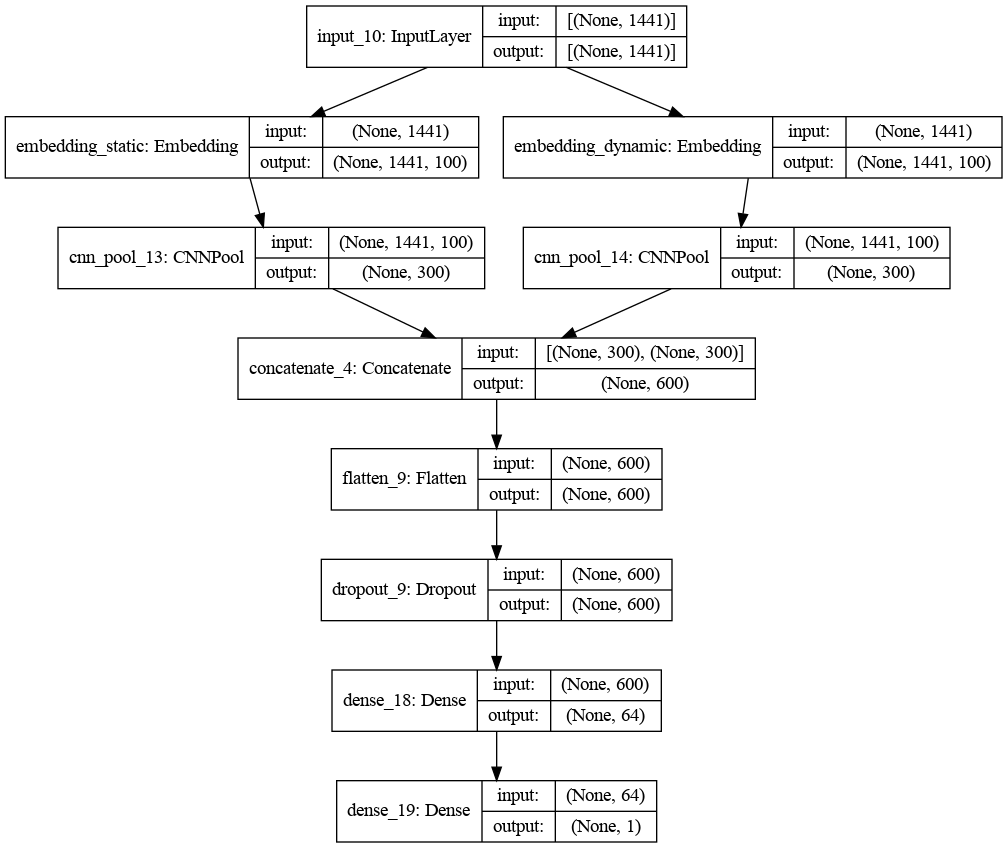

In [54]:
# print(shallow_model.summary())
plot_model(kim_model, to_file='./assets/kim_model_plot.png', show_shapes=True, show_layer_names=True)

In [55]:
if num_classes == 1 :
    kim_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )
else :
    kim_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=["accuracy"],
    )

history_kim = kim_model.fit(x_train, y_train, validation_split=0.2, batch_size=50, epochs=6, verbose=2)
kim_model.evaluate(x_test, y_test, batch_size=50, verbose=2)

Epoch 1/6
480/480 - 76s - loss: 0.7065 - accuracy: 0.5149 - val_loss: 0.6904 - val_accuracy: 0.4948
Epoch 2/6
480/480 - 76s - loss: 0.5895 - accuracy: 0.6712 - val_loss: 0.4107 - val_accuracy: 0.8217
Epoch 3/6
480/480 - 76s - loss: 0.3238 - accuracy: 0.8585 - val_loss: 0.3424 - val_accuracy: 0.8538
Epoch 4/6
480/480 - 77s - loss: 0.1534 - accuracy: 0.9431 - val_loss: 0.3483 - val_accuracy: 0.8650
Epoch 5/6
480/480 - 77s - loss: 0.0624 - accuracy: 0.9795 - val_loss: 0.4381 - val_accuracy: 0.8645
Epoch 6/6
480/480 - 78s - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.5604 - val_accuracy: 0.8595
400/400 - 15s - loss: 0.5120 - accuracy: 0.8619


[0.5120291709899902, 0.8619499802589417]

In [56]:
if num_classes == 1 :
    shallow_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )
else :
    shallow_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=["accuracy"],
    )

history_shallow = shallow_model.fit(x_train, y_train, validation_split=0.2, batch_size=50, epochs=6, verbose=2)
shallow_model.evaluate(x_test, y_test, batch_size=50, verbose=2)

Epoch 1/6
480/480 - 52s - loss: 0.5247 - accuracy: 0.7068 - val_loss: 0.3095 - val_accuracy: 0.8668
Epoch 2/6
480/480 - 52s - loss: 0.2609 - accuracy: 0.8947 - val_loss: 0.2941 - val_accuracy: 0.8770
Epoch 3/6
480/480 - 52s - loss: 0.1322 - accuracy: 0.9503 - val_loss: 0.2864 - val_accuracy: 0.8918
Epoch 4/6
480/480 - 52s - loss: 0.0558 - accuracy: 0.9798 - val_loss: 0.3593 - val_accuracy: 0.8847
Epoch 5/6
480/480 - 52s - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.4189 - val_accuracy: 0.8840
Epoch 6/6
480/480 - 52s - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.4924 - val_accuracy: 0.8795
400/400 - 8s - loss: 0.4979 - accuracy: 0.8801


[0.4979420304298401, 0.8801000118255615]

# Plots for accuracy and loss on both models

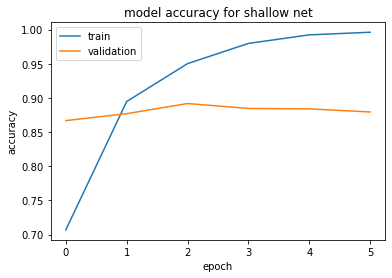

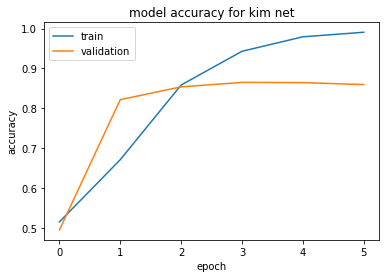

In [58]:
# plot accuracy v/s epochs of the model

plt.plot(history_shallow.history['accuracy'])
plt.plot(history_shallow.history['val_accuracy'])
plt.title('model accuracy for shallow net')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_kim.history['accuracy'])
plt.plot(history_kim.history['val_accuracy'])
plt.title('model accuracy for kim net')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

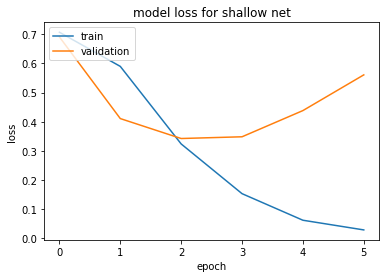

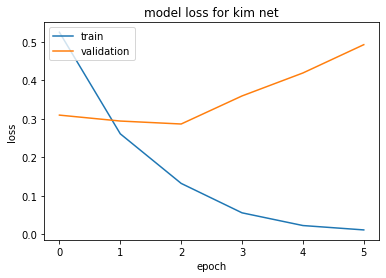

In [59]:
# plot loss v/s epochs of the model

plt.plot(history_kim.history['loss'])
plt.plot(history_kim.history['val_loss'])
plt.title('model loss for shallow net')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_shallow.history['loss'])
plt.plot(history_shallow.history['val_loss'])
plt.title('model loss for kim net')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Word embeddings visualized 

In [68]:
# get embedding matrix from the embedding layer of the model

shalllow_embedding = shallow_model.get_layer('embedding_rand').get_weights()[0]
# shalllow_embedding = shallow_model.get_layer('embedding_static').get_weights()[0]
# shalllow_embedding = shallow_model.get_layer('embedding_dynamic').get_weights()[0]

kim_embedding_static = kim_model.get_layer('embedding_static').get_weights()[0]
kim_embedding_dynamic = kim_model.get_layer('embedding_dynamic').get_weights()[0]

In [69]:
# reduce dimensionality of word embeddings to 2

pca = PCA(n_components=2)
shallow_result = pca.fit_transform(shalllow_embedding[:200])
# kim_static_result = pca.fit_transform(kim_embedding_static[:200])
kim_dynamic_result = pca.fit_transform(kim_embedding_dynamic[:200])

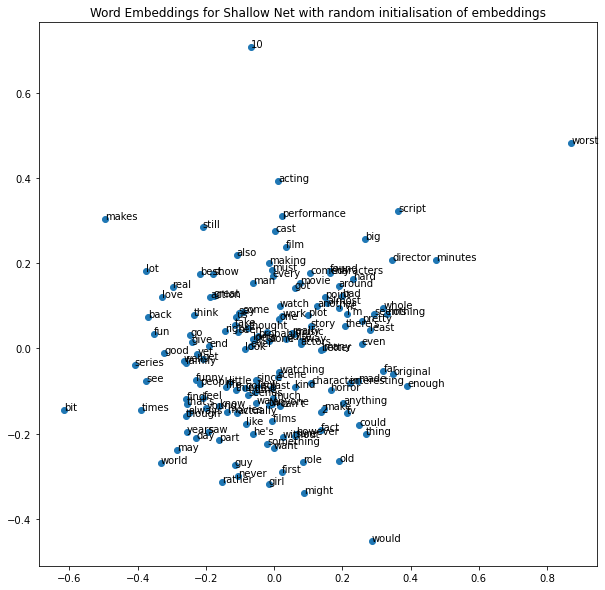

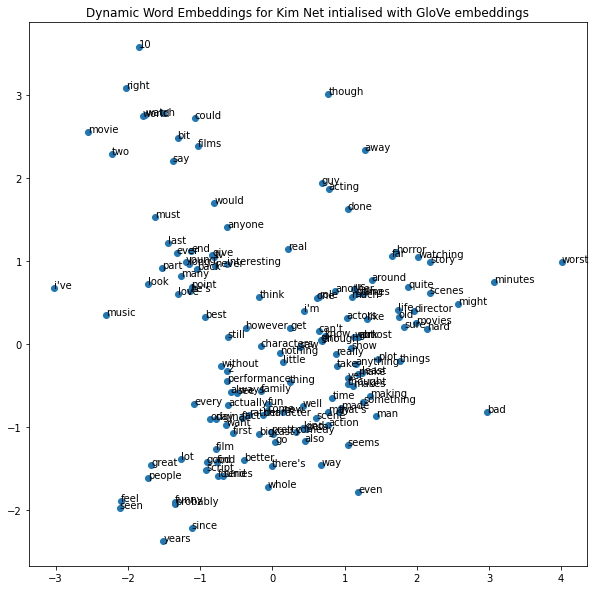

In [70]:
# plot of the word embeddings of the Shallow net model to display similarity between words with random initialisation

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

plt.scatter(shallow_result[:150, 0], shallow_result[:150, 1])
k=0
for word, i in vocabulary.items():
    k+=1
    if k >=150 :
        break
    plt.annotate(word, xy=(shallow_result[i, 0], shallow_result[i, 1]))
plt.title('Word Embeddings for Shallow Net with random initialisation of embeddings')
plt.show()


# plot of the dynamic word embeddings of the Kim net model to display similarity between words
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)


plt.scatter(kim_dynamic_result[:150, 0], kim_dynamic_result[:150, 1])
k=0
for word, i in vocabulary.items():
    k+=1
    if k >= 150 :
        break
    plt.annotate(word, xy=(kim_dynamic_result[i, 0], kim_dynamic_result[i, 1]))
plt.title('Dynamic Word Embeddings for Kim Net intialised with GloVe embeddings')
plt.show()
